# 0. Settings.

In [1]:
# Imports.
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Disable unnecessary warnings.
import logging
logging.basicConfig(level=logging.ERROR)

import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# Random seed.
from transformers import set_seed
set_seed(42)

# 1. About.

- **Description**  
  This project is to develop a simple NLP model with IMDb, that classifies the sentiment of the movie review.  
  This project clearly shows a typical workflow of fine-tuning of LLM for specific tasks.
- **Duration**  
  - Start Date: 2024.12.25.  
  - End Date: 2024.12.27.
- **I/O**  
  - **Input**: a list of `str`.  
    A raw text sequence for movie review, written in English.
  - **Output**: `{0, 1}`.  
    Sentiment. 0 = Negative, 1 = Positive.
- **Type of Task**
  - Text Classification.
  - Sentiment Analysis.
- **Domain**  
  Movie, Media, Review
- **Data**
  - IMDb dataset.  
- **Performance Metrics**  
  - Accuracy.
- **Result**  
  - Model: DistilBERT with fine-tuning. 
  - Performance: 91.74% of accuracy.
- **Change Log**  
  - 2024.12.27, 1st written.

# 2. Data Preparation and EDA.

- [IMDb Dataset](https://huggingface.co/datasets/stanfordnlp/imdb?utm_source=chatgpt.com).

## 2.1. Load.

In [2]:
from datasets import load_dataset
ds       = load_dataset(path='imdb')
train_ds = ds['train']
test_ds  = ds['test']

## 2.2. EDA.

In [3]:
# Temporary convert to pd.DataFrame for EDA.
train_df = train_ds.to_pandas()

> #### Note) Use `.to_pandas()` instead.  
> It only changes the interface, instead of actual conversion, but the original `train_ds` is not affected.

### 2.2.1. Basic Exploration.

In [10]:
# Number of train samples.
num_train   = len(train_df)                        
print(f'- num_train : {num_train}')    

# Print some samples.
print(f'- Some samples.')
for i in range(3):
    sample = train_df.iloc[i]
    print(f'text : {sample["text"][:100]}')
    print(f'label : {sample["label"]}', end='\n\n')  

- num_train : 25000
- Some samples.
text : I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w
label : 0

text : "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's poli
label : 0

text : If only to avoid making this type of film in the future. This film is interesting as an experiment b
label : 0



### 2.2.2. Null Check.

In [20]:
print(train_df.isnull().sum())
print('=> Clear!')

text     0
label    0
dtype: int64
=> Clear!


### 2.2.3. Class Distribution.


- Class Distribution:


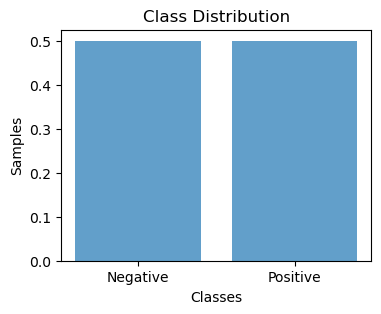

In [14]:
print("\n- Class Distribution:")
class_counts = train_df['label'].value_counts()

plt.figure(figsize=(4, 3))
plt.bar(class_counts.index, class_counts.values / num_train, 
        alpha=0.7, tick_label=["Negative", "Positive"])
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Samples")
plt.show()

### 2.2.4. Length of Texts.

Average Character Length: 1325.07
Average Word Length: 233.78



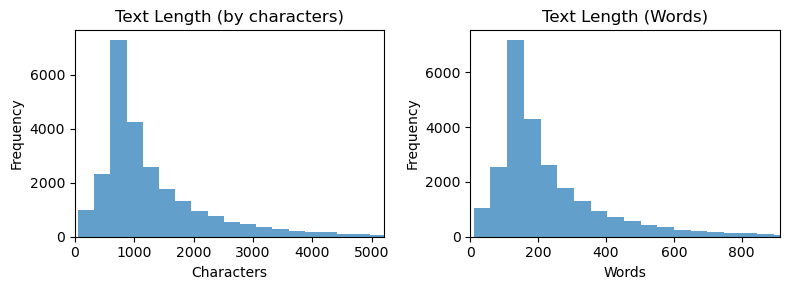

In [29]:
# Average length.
train_df['char_length'] = train_df['text'].apply(len)
train_df['word_length'] = train_df['text'].apply(lambda x: len(x.split(' ')))

avg_char_length = train_df['char_length'].mean().round(2)
avg_word_length = train_df['word_length'].mean().round(2)

print(f"Average Character Length: {avg_char_length}")
print(f"Average Word Length: {avg_word_length}", end='\n\n')

# Draw histogram.
plt.figure(figsize=(8, 3))

# By character.
plt.subplot(1, 2, 1)
plt.hist(train_df['char_length'], bins=50, alpha=0.7)     
plt.title('Text Length (by characters)')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.xlim(0, np.percentile(train_df['char_length'], 99))   # truncate 1% outlier.

# By word.
plt.subplot(1, 2, 2)
plt.hist(train_df['word_length'], bins=50, alpha=0.7)     
plt.title('Text Length (Words)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xlim(0, np.percentile(train_df['word_length'], 99))

plt.tight_layout()
plt.show()

### 2.2.5. Length by Class.

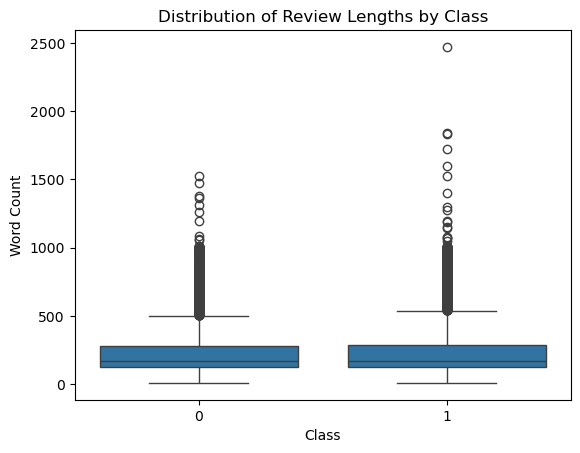

In [30]:
import seaborn as sns
sns.boxplot(x=train_df['label'], y=train_df['word_length'])
plt.title("Distribution of Review Lengths by Class")
plt.xlabel("Class")
plt.ylabel("Word Count")
plt.show()

### 2.2.6. Frequent words for each class.
- In this case, since the dataset is not large, we can count words to calculate top words.
- Shared words are excluded.
- Not all but some words clearly seem to be useful! We could try them for fine-tuning.

In [40]:
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Exclude some frequent words that are rarely meaningful.
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Method : list of txts -> top_ most frequent words. 
def get_top_words(texts, top_n):
    words = [
        word 
        for text in texts 
        for word in text.split() 
        if word.lower() not in stop_words and word.isalpha()
    ]
    return Counter(words).most_common(top_n)

# Separate reviews by class.
pos_reviews   = train_df[train_df['label'] == 1]['text']
neg_reviews   = train_df[train_df['label'] == 0]['text']

# Get top words for both classes.
pos_top_words = get_top_words(pos_reviews, top_n=50)
neg_top_words = get_top_words(neg_reviews, top_n=50)

# Filter shared words.
shared_words  = set(word for word, _ in pos_top_words) & set(word for word, _ in neg_top_words)
pos_filtered  = [(word, count) for word, count in pos_top_words if word not in shared_words][:10]
neg_filtered  = [(word, count) for word, count in neg_top_words if word not in shared_words][:10]

# Print top words.
print('Top Words : Positive Reviews')
for p in pos_filtered:
    print(p)
    
print('\nTop Words : Negative Reviews')
for n in neg_filtered:
    print(n)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top Words : Positive Reviews
('well', 3607)
('best', 3387)
('love', 3326)
('still', 2909)
('makes', 2345)
('life', 2340)
('find', 2184)
('back', 2110)
('real', 2063)
('quite', 2063)

Top Words : Negative Reviews
('bad', 5096)
('plot', 2953)
('acting', 2850)
('better', 2527)
('something', 2390)
('nothing', 2355)
('watching', 2303)
('thing', 2223)
('actually', 2216)
('going', 2142)


### 2.2.7. Convert back to `dataset`.

In [41]:
from datasets import Dataset
train_ds = Dataset.from_pandas(train_df)

# 3. Model - Baselines.

## 3.1. Naive Classifier.

- Always predict the most frequent class.
- In this case, 1, for 'pos'.

In [11]:
model_clf = lambda samples : [1] * len(samples)

## 3.2. BoW + Simple Classifiers.

- Bag of Words : Simple tokenizer.
  - Split : Whitespaces and punctuations.
  - Tokenization : Counter vector, where each element is the number of words in a given sentence.
- Simple Classifiers.
  - Logistic Regression.
  - SVM.

In [42]:
# LR.
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

model_lr = Pipeline([
    ('vectorizer', CountVectorizer()),  
    ('classifier', LogisticRegression(max_iter=1000))  
])

for _ in tqdm(range(1), desc="Training Logistic Regression."):
    model_lr.fit(train_ds['text'], train_ds['label'])

Training Logistic Regression.: 100%|█████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.78s/it]


In [43]:
# SVM.
from sklearn.svm import LinearSVC
model_svm = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LinearSVC())
])

for _ in tqdm(range(1), desc="Training SVM."):
    model_svm.fit(train_ds['text'], train_ds['label'])

C:\Users\yana\anaconda3\envs\nlp_prac\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Training SVM.: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.15s/it]


## 3.3. Simple RNN.

In [44]:
from transformers import AutoTokenizer
import tensorflow as tf

tf_layers = tf.keras.layers  # alias for keras layers.

# Tokenization.
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
max_len   = int(np.percentile(train_df['word_length'], 75))       # 3rd quartile, 284.

x_train = tokenizer(
    train_ds['text'],
    max_length=max_len,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)['input_ids']

y_train = tf.keras.utils.to_categorical(train_ds['label'], num_classes=2)  # One-hot encoding labels.

# Model.
model_rnn = tf.keras.models.Sequential([
    tf_layers.Embedding(input_dim=tokenizer.vocab_size, 
                        output_dim=20, 
                        input_length=max_len),  
    tf_layers.SimpleRNN(64),  
    tf_layers.Dense(2, activation='softmax')
])

# Compile.
model_rnn.compile(optimizer = 'adam', 
                  loss      = 'categorical_crossentropy', 
                  metrics   = ['accuracy'])

# Fit.
history = model_rnn.fit(
    x_train, y_train,
    epochs=1,
    batch_size=32,
    verbose=1
)

782/782 [==============================] - 38s 48ms/step - loss: 0.7008 - accuracy: 0.4988


## 3.4. Performance Comparison.

In [45]:
from sklearn.metrics import accuracy_score
accuracy = {}

# LR.
y_pred_lr       = model_lr.predict(test_ds['text'])
accuracy['lr']  = accuracy_score(test_ds['label'], y_pred_lr)

# SVM.
y_pred_svm      = model_svm.predict(test_ds['text'])
accuracy['svm'] = accuracy_score(test_ds['label'], y_pred_svm)

# Simple RNN.
x_test = tokenizer(test_ds['text'],
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_tensors='tf')
y_pred_rnn = model_rnn.predict(x_test['input_ids']).argmax(axis=1)
accuracy['rnn'] = accuracy_score(test_ds['label'], y_pred_rnn)

print(accuracy)

782/782 [==============================] - 11s 14ms/step
{'lr': 0.86636, 'svm': 0.84576, 'rnn': 0.5018}


## 3.5. Insights.

- The strong performance of LR and SVM shows that many reviews are straightforward, and sentiment can often be determined by key words. However:
  - Pretrained models add value where BoW fails, such as handling:
    - Nuances in language: sarcasm, negation, and subtle opinions.
    - Contextual relationships: the importance of word combinations or sequences.
  - If pretrained models do not significantly outperform LR or SVM, it may indicate that the task is dominated by these simpler patterns.

# 4. Choosing Pretrained Model.

## 4.1. Given Conditions.
- **Task**: Typical text classification, sentiment analysis.
- **Dataset Size**: 25,000 labeled examples.
- **Resources**: Single GPU with 8GB VRAM.
- **Deployment Needs**: (Probably) Moderate inference speed.

## 4.2. Candidates.
- Encoder-only models are ideal for classification tasks.
- Lightweight models are chosen due to limited resources and small dataset size.
- Candidates:
  - **DistilBERT** for simplicity and balance.
  - **ALBERT** for better memory efficiency.
  - **MobileBERT** for faster inference.

## 4.3. Choosing the Model.

### 1. Better Contextual Understanding.
- **Factorized Embedding Parameterization**:
  - ALBERT can represent relationships between words more effectively.
  - This is crucial for understanding nuanced sentiment in IMDb reviews (e.g., sarcasm, complex sentence structures).
  - DistilBERT simplifies BERT’s architecture, which reduces its ability to handle such complexity.

### 2. Sentence Coherence (SOP Pretraining).
- ALBERT’s **Sentence Order Prediction (SOP)** objective enhances its ability to grasp sentence-level relationships.
  - IMDb reviews often depend on understanding the flow of multiple sentences.
  - DistilBERT and MobileBERT lack SOP pretraining, making them less capable of capturing such coherence.

### 3. Parameter Efficiency.
- ALBERT’s parameter-sharing strategy enables deeper learning without increasing model size.
  - This depth helps ALBERT extract more robust features for IMDb sentiment analysis, where contextual nuances are critical.

### 4. Limitations of DistilBERT and MobileBERT.
- **DistilBERT**:
  - Designed for speed and efficiency but sacrifices some representational power.
  - Works well for simple tasks but underperforms on sentiment analysis involving long, complex reviews.
- **MobileBERT**:
  - Optimized for mobile and edge devices, focusing on inference speed rather than peak accuracy.
  - Struggles with capturing deep contextual meaning compared to ALBERT.

## 4.4. Conclusion.
- **DistilBERT** for speed and efficiency.
- **ALBERT** for performance.

# 5. Fine-Tuning.

## 5.1. Tokenization.

In [46]:
# Prepare the data.
from datasets import load_dataset
ds       = load_dataset(path='imdb')
train_ds = ds['train']
test_ds  = ds['test']

# Define maximum length for padding/truncation.
train_df                = train_ds.to_pandas() 
train_df['word_length'] = train_df['text'].apply(lambda x: len(x.split()))
avg_word_length         = train_df['word_length'].mean()
max_length              = int(np.percentile(train_df["word_length"], 75))   # 284.
# max_length = 128

# Load pretrained LLM.
from transformers import AutoTokenizer
tokenizer  = AutoTokenizer.from_pretrained(checkpoint)

# Tokenize the data.
def tokenize_data(dataset):
    tokens = tokenizer(
        dataset["text"],
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"  
    )
    labels = torch.tensor(dataset["label"])  # Convert labels to PyTorch tensors.
    return tokens["input_ids"], tokens["attention_mask"], labels

train_input_ids, train_attention_mask, train_labels = tokenize_data(train_ds)
test_input_ids, test_attention_mask, test_labels    = tokenize_data(test_ds)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 5.2. Training.

In [47]:
from transformers import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast

def train_model(train_dataloader, test_dataloader, model, device, full_tuning=True, epochs=1):
    """
    Train the model with an option for full training or head-only training.
    
    Args:
        train_dataloader: DataLoader for training data.
        test_dataloader: DataLoader for testing data.
        model: Pretrained transformer model.
        device: Device (GPU/CPU) to run the training.
        full_tuning (bool): If True, trains the full model. If False, trains only the head.
        epochs (int): Number of epochs to train.
    """
    # Freeze body if not tuning the full model.
    if not full_tuning:
        for param in model.base_model.parameters():
            param.requires_grad = False

    # Optimizer and loss function.
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
    loss_fn   = CrossEntropyLoss()

    # Enable mixed precision training.
    scaler    = GradScaler()

    # Training loop.
    model.train()
    for epoch in range(epochs):
        total_loss   = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for batch in progress_bar:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            optimizer.zero_grad()
            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
                loss    = loss_fn(outputs.logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        
        print(f"Epoch {epoch+1}: Average Loss: {total_loss/len(train_dataloader):.4f}.")

    # Evaluation loop.
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, axis=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate accuracy and print.
    from sklearn.metrics import accuracy_score
    
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy:.4f}")

    #import winsound
    #path = r"C:\Windows\Media\Alarm03.wav"
    #winsound.PlaySound(path, winsound.SND_FILENAME)

In [50]:
# Model.
from transformers import AutoModelForSequenceClassification

checkpoint = "albert-base-v2"  
# checkpoint = "distilbert-base-uncased"
model      = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)  # Predefined head.
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [ ]:
# Create PyTorch datasets and dataloaders.
batch_size       = 64
train_dataset    = TensorDataset(train_input_ids, train_attention_mask, train_labels)  
test_dataset     = TensorDataset(test_input_ids, test_attention_mask, test_labels)  

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, 
                              num_workers=8, pin_memory=True)                                        # To boost training.
test_dataloader  = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

# Train.
%time train_model(train_dataloader, test_dataloader, model, device, full_tuning=True, epochs=2)      # Full training.
%time train_model(train_dataloader, test_dataloader, model, device, full_tuning=False, epochs=20)    # Head-only training.

C:\Users\yana\anaconda3\envs\nlp_prac\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\yana\AppData\Local\Temp\ipykernel_6684\1522156939.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()
C:\Users\yana\AppData\Local\Temp\ipykernel_6684\1522156939.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/2:  40%|██████████████████████▌                                  | 155/391 [22:33<34:20,  8.73s/it, loss=0.687]


KeyboardInterrupt: 

Epoch 1/20:  38%|█████████████████████▏                                  | 148/391 [09:25<14:57,  3.69s/it, loss=0.669]